In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [39]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [40]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

In [41]:
import matplotlib.pyplot as plt

In [42]:
transform = transforms.ToTensor()

In [43]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)

In [44]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [45]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [46]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [47]:
image,label = train_data[0]

In [48]:
image.shape

torch.Size([1, 28, 28])

In [49]:
label

5

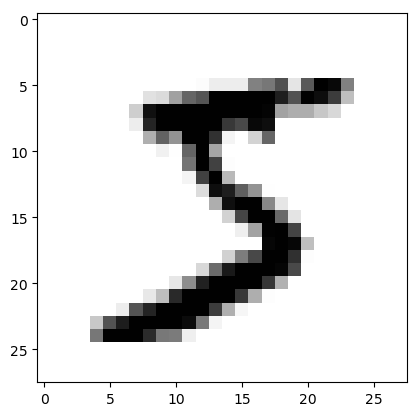

In [50]:
plt.imshow(image.reshape(28,28), cmap='gist_yarg')

In [51]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


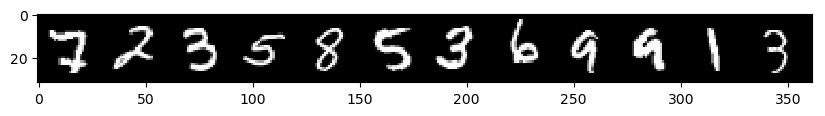

In [52]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC as torchvision expects
#Width,Height,Color format
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [53]:
class MLP(nn.Module):
    
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [54]:
torch.manual_seed(101)
model = MLP()
model

MLP(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [55]:
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [57]:
images.shape

torch.Size([100, 1, 28, 28])

In [58]:
images.view(100,-1).shape

torch.Size([100, 784])

In [62]:
import time
start_time = time.time()

epochs = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            acc = trn_corr.item()*100/(100*b)
            print(f'epoch: {i}  batch: {b}  loss: {loss.item()}   accuracy:{acc}')
            
                  
    train_losses.append(loss)
    train_correct.append(trn_corr)


    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
                  
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)




total_time = time.time() - start_time
print(f'Duration: {total_time/60}mins')

epoch: 0  batch: 200  loss: 0.2598460018634796   accuracy:82.675
epoch: 0  batch: 400  loss: 0.22249099612236023   accuracy:87.2975
epoch: 0  batch: 600  loss: 0.15284788608551025   accuracy:89.26666666666667
epoch: 1  batch: 200  loss: 0.05919573828577995   accuracy:94.71
epoch: 1  batch: 400  loss: 0.24021154642105103   accuracy:94.99
epoch: 1  batch: 600  loss: 0.052581384778022766   accuracy:95.27166666666666
epoch: 2  batch: 200  loss: 0.06413063406944275   accuracy:96.43
epoch: 2  batch: 400  loss: 0.19072028994560242   accuracy:96.6475
epoch: 2  batch: 600  loss: 0.10412359982728958   accuracy:96.715
epoch: 3  batch: 200  loss: 0.04990239441394806   accuracy:97.42
epoch: 3  batch: 400  loss: 0.14827218651771545   accuracy:97.4075
epoch: 3  batch: 600  loss: 0.20663650333881378   accuracy:97.44666666666667
epoch: 4  batch: 200  loss: 0.14761540293693542   accuracy:97.99
epoch: 4  batch: 400  loss: 0.051319170743227005   accuracy:97.955
epoch: 4  batch: 600  loss: 0.08019807189702

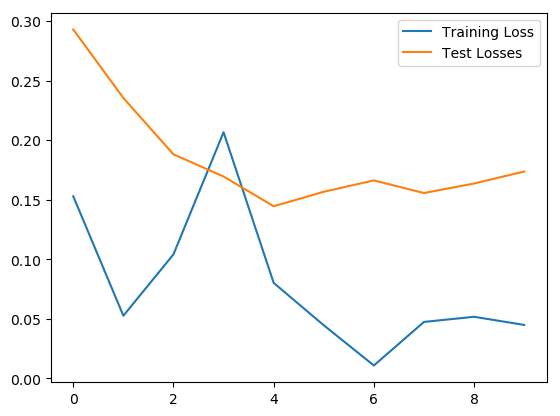

In [64]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Losses')
plt.legend()

In [71]:
train_acc = [t/600 for t in train_correct]

In [72]:
train_acc

[tensor(89.2667),
 tensor(95.2717),
 tensor(96.7150),
 tensor(97.4467),
 tensor(97.9783),
 tensor(98.3033),
 tensor(98.6133),
 tensor(98.8500),
 tensor(98.9967),
 tensor(99.1967)]

In [73]:
test_acc = [t/100 for t in test_correct]

In [74]:
test_acc

[tensor(94.1300),
 tensor(96.0600),
 tensor(96.8200),
 tensor(97.0900),
 tensor(97.2000),
 tensor(97.4200),
 tensor(97.4700),
 tensor(97.2700),
 tensor(97.4100),
 tensor(97.5300)]

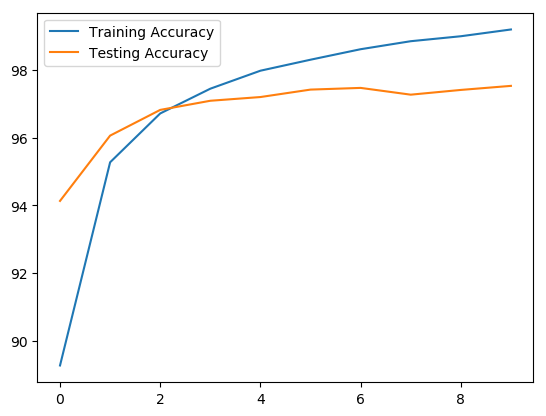

In [76]:
plt.plot(train_acc, label = 'Training Accuracy')
plt.plot(test_acc, label = 'Testing Accuracy')
plt.legend()

In [77]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [78]:
with torch.no_grad():
    
    
    correct = 0
    
    for X_test, y_test in test_load_all:
        
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

In [80]:
correct.item()/len(test_data)*100

97.53

In [81]:
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[ 966    0    6    0    0    2    3    1    5    0]
 [   1 1126    2    1    0    0    3    8    0    3]
 [   0    2  999    4    3    0    2    6    2    0]
 [   2    3    6  985    0    5    1    4   10    2]
 [   2    0    3    0  974    1   10    3    6   15]
 [   1    1    0    8    1  875   12    0   12    5]
 [   3    1    3    0    0    3  927    0    3    0]
 [   1    0    3    3    1    1    0  992    3    2]
 [   2    2    9    1    0    4    0    2  927    0]
 [   2    0    1    8    3    1    0   12    6  982]]
